In [1]:
import pandas as pd
import torch
import os
import sys
import librosa
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../audio_preprocessing')
sys.path.append('../src')
sys.path.append('../model_training_utils')

import preprocessing_func
from generator_to_dataset import NormalisedDataSet, NonNormalisedTestModelsDataSet
from gdsc_utils import PROJECT_DIR
import model_training

os.chdir(PROJECT_DIR)

In [2]:
df = pd.read_csv('data/metadata.csv')
df_train = df[df["subset"] == "train"]
df_val = df[df["subset"] == "validation"]
df_train.head()

,file_name,unique_file,path,species,label,subset,sample_rate,num_frames,length
0,Roeselianaroeselii_XC751814-dat028-019_edit1.wav,Roeselianaroeselii_XC751814-dat028-019,data/train/Roeselianaroeselii_XC751814-dat028-...,Roeselianaroeselii,56,train,44100,4586400,104.000000
1,Roeselianaroeselii_XC752367-dat006-010.wav,Roeselianaroeselii_XC752367-dat006-010,data/train/Roeselianaroeselii_XC752367-dat006-...,Roeselianaroeselii,56,train,44100,337571,7.654671
2,Yoyettacelis_GBIF2465208563_IN36000894_50988.wav,Yoyettacelis_GBIF2465208563_IN36000894_50988,data/train/Yoyettacelis_GBIF2465208563_IN36000...,Yoyettacelis,64,train,44100,220500,5.000000
3,Gomphocerippusrufus_XC752285-dat001-045.wav,Gomphocerippusrufus_XC752285-dat001-045,data/train/Gomphocerippusrufus_XC752285-dat001...,Gomphocerippusrufus,26,train,44100,693715,15.730499
5,Phaneropteranana_XC755717-221013-Phaneroptera-...,Phaneropteranana_XC755717-221013-Phaneroptera-...,data/train/Phaneropteranana_XC755717-221013-Ph...,Phaneropteranana,41,train,44100,88200,2.000000


In [3]:
paths, labels = list(df_train["path"][30:31]), list(df_train["label"][0:1])

In [4]:
print(paths)

['data/train/Omocestusrufipes_XC751625-dat015-008_edit1.wav']


In [5]:
generator = preprocessing_func.non_normalised_data_generator_new(paths, labels)

In [6]:
graphs = []
for image, _ in generator:
    graphs.append(image)
    print(image.shape)

data/train/Omocestusrufipes_XC751625-dat015-008_edit1.wav
(1, 128, 1034)
(1, 128, 1034)
(1, 128, 1034)
(1, 128, 1034)
(1, 128, 1034)
(1, 128, 1034)


In [7]:
# for image, _ in generator:
#     if image.shape[1] != 128 or image.shape[2] != 376:
#         print(image.shape)

In [8]:
def test_split(paths):
    for path in paths:
        wav = preprocessing_func.change_wav_sample_rate(path)[0]
        chunks = preprocessing_func.split_wav_to_n_seconds_chunks(wav)
        print(chunks[0].shape, chunks[-2].shape, chunks[-1].shape)
        break

In [9]:
graphs[3][0]

array([[-1.2911285 , -0.86396843, -0.66360724, ..., -1.0508032 ,
        -1.0548823 , -0.9696364 ],
       [-1.0208532 , -0.7829401 , -0.6557621 , ..., -0.94092345,
        -0.935493  , -0.95467323],
       [-1.0582383 , -0.96545583, -1.0015291 , ..., -0.9531995 ,
        -0.96751416, -1.0476768 ],
       ...,
       [-1.6468103 , -1.5363964 , -1.4886138 , ..., -1.413862  ,
        -1.4258646 , -1.486288  ],
       [-1.8581327 , -1.7509148 , -1.6745934 , ..., -1.561488  ,
        -1.5875607 , -1.6160463 ],
       [-1.8112186 , -1.7271625 , -1.7445668 , ..., -1.5313329 ,
        -1.5331985 , -1.5789381 ]], dtype=float32)

In [10]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='equal', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

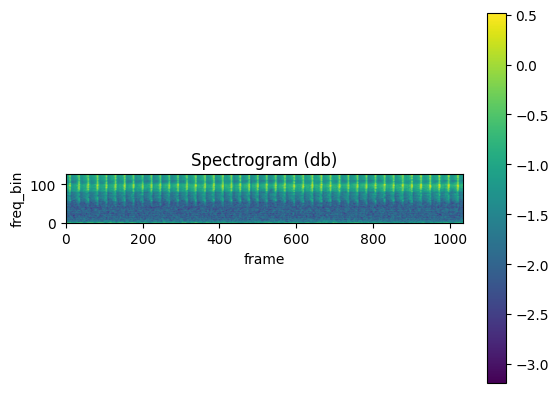

In [11]:
plot_spectrogram(graphs[3][0])

In [12]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [13]:
wav, sample_rate = preprocessing_func.change_wav_sample_rate(paths[0])
wav = wav[:,48000*3:48000*4].numpy()
melspec = calculate_melsp(wav[0])

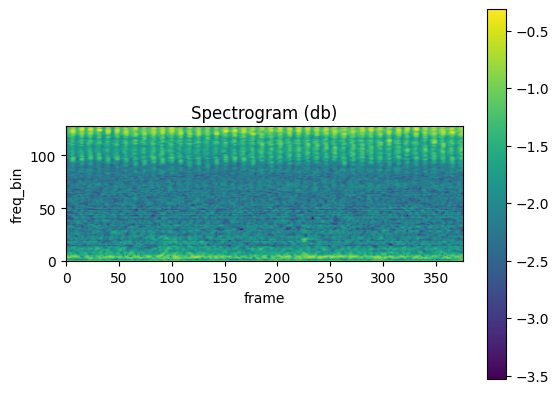

In [14]:
plot_spectrogram(melspec)

In [15]:
wav.shape

(1, 48000)

In [16]:
new_path = "data/train/Eumodicogryllusbordigalensis_XC752108-dat172-003_edit8.wav"

down_sampled_wav, _ = preprocessing_func.change_wav_sample_rate(new_path)
normal_wav = librosa.load(new_path, sr=44100)

down_sampled_spec = calculate_melsp(down_sampled_wav.numpy())
normal_spec = calculate_melsp(normal_wav[0])

In [17]:
down_sampled_spec.shape, normal_spec.shape

((1, 128, 251), (128, 690))

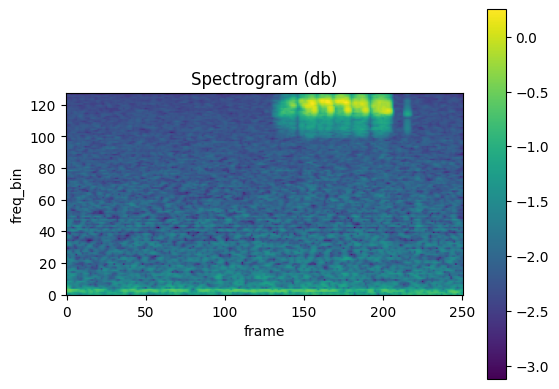

In [18]:
plot_spectrogram(down_sampled_spec[0])

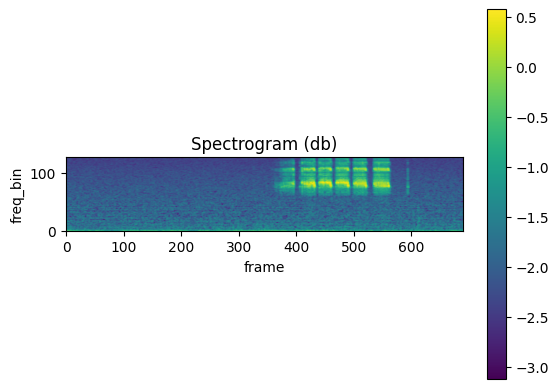

In [19]:
plot_spectrogram(normal_spec)

In [20]:
trimed_down_sampled_wav,_ = librosa.effects.trim(down_sampled_wav)
trimed_normal_wav, index = librosa.effects.trim(normal_wav[0], top_db=100)

trimed_down_sampled_spec = calculate_melsp(trimed_down_sampled_wav.numpy())
trimed_normal_spec = calculate_melsp(trimed_normal_wav)

In [21]:
index

array([    0, 88200])

In [22]:
trimed_normal_wav.shape, normal_wav[0].shape

((88200,), (88200,))

In [23]:
#trimed_normal_wav[43000: 43100]

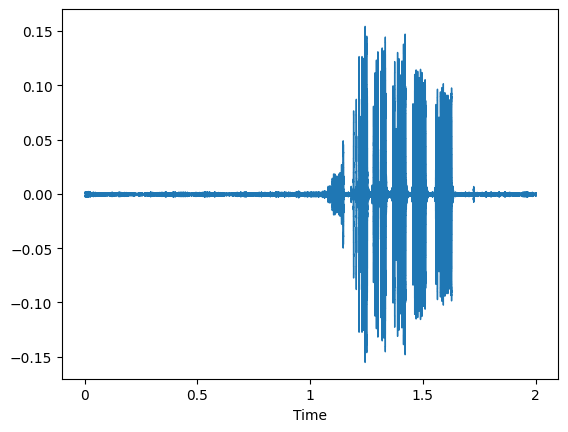

In [24]:
import librosa.display

librosa.display.waveshow(trimed_normal_wav, sr=44100)

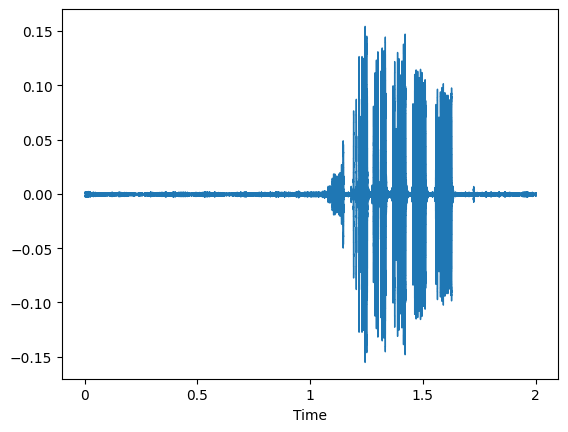

In [25]:
librosa.display.waveshow(normal_wav[0], sr=44100)

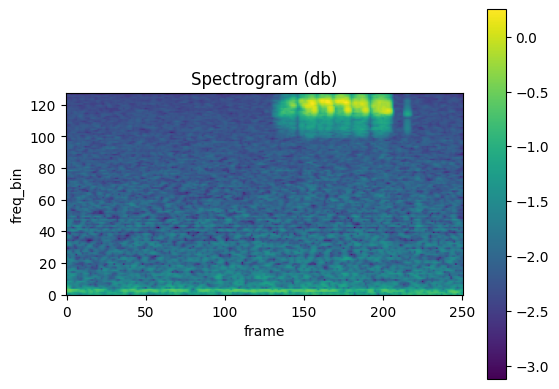

In [26]:
plot_spectrogram(trimed_down_sampled_spec[0])

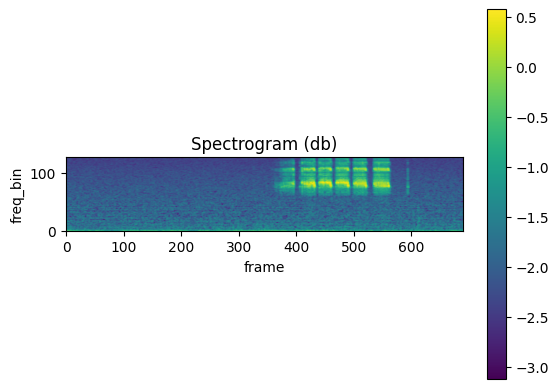

In [27]:
plot_spectrogram(trimed_normal_spec)

In [28]:
trimed_down_sampled_spec.shape

(1, 128, 251)

In [29]:
def calculate_fft(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    return stft

In [30]:
normal_wav

(array([0.00134277, 0.00152588, 0.00189209, ..., 0.00054932, 0.00067139,
        0.00085449], dtype=float32),
 44100)

In [31]:
stft = calculate_fft(normal_wav[0])

In [32]:
stft.shape

(513, 690)

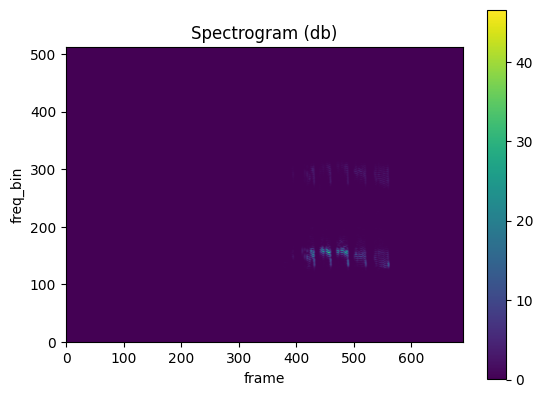

In [33]:
plot_spectrogram(stft)

In [34]:
new_paths, new_labels = list(df_train["path"]), list(df_train["label"])

new_generator = preprocessing_func.non_normalised_data_generator_new(new_paths, new_labels)

In [35]:
shape = (1, 128, 1034)

for image, _ in new_generator:
    if image.shape[1] != shape[1] or image.shape[2] != shape[2]:
        print(image.shape)

data/train/Roeselianaroeselii_XC751814-dat028-019_edit1.wav
data/train/Roeselianaroeselii_XC752367-dat006-010.wav
data/train/Yoyettacelis_GBIF2465208563_IN36000894_50988.wav
data/train/Gomphocerippusrufus_XC752285-dat001-045.wav
data/train/Phaneropteranana_XC755717-221013-Phaneroptera-nana-Spontangesang-FH-1918-14°C_edit4.wav
data/train/Eupholidopteraschmidti_XC752430-dat051-014_edit1.wav
data/train/Chorthippusapricarius_XC752128-dat028-008_edit4.wav
data/train/Pholidopteraaptera_XC751363-dat145-003_edit3.wav
data/train/Chorthippusmollis_XC752529-dat186-002_edit1.wav
data/train/Tettigoniaviridissima_200726_0062.M.wav
data/train/Yoyettacelis_GBIF1935609794_IN18143852_27225.wav
data/train/Chorthippusbrunneus_XC751407-dat024-016_edit3.wav
data/train/Omocestusviridulus_XC752264-dat012-008_edit13.wav
data/train/Yoyettacelis_GBIF2868112079_IN60578753_138082.wav
data/train/Yoyettacelis_GBIF2429339163_IN33733855_47840.wav
data/train/Conocephalusfuscus_XC751488-dat129-010_edit2.wav
data/train/C

data/train/Conocephalusfuscus_XC751488-dat129-010_edit3.wav
data/train/Omocestusviridulus_XC752264-dat012-008_edit12.wav
data/train/Chorthippusbrunneus_XC751407-dat024-016_edit2.wav
data/train/Achetadomesticus_XC751738-dat004-038.wav
data/train/Chorthippusapricarius_XC752590-dat004-011.wav
data/train/Nemobiussylvestris_XC752026-dat006-004_edit1.wav
data/train/Pholidopteraaptera_XC751363-dat145-003_edit2.wav
data/train/Phaneropteranana_XC755717-221013-Phaneroptera-nana-Spontangesang-FH-1918-14°C_edit5.wav
data/train/Chorthippusapricarius_XC752128-dat028-008_edit5.wav
data/train/Yoyettacelis_GBIF3031725753_IN68038441_158517_edit2.wav
data/train/Platypleurasp12cfhirtipennis_MHV%20602%20P.sp12%2020km%20SE%20Prince%20Albert_edit2.wav
data/train/Clinopsaltaautumna_GBIF1949986195_IN18667268_27938_edit2.wav
data/train/Popplepsaltanotialis_GBIF2529284366_IN36634538_52768.wav
data/train/Roeselianaroeselii_XC751814-dat028-019_edit2.wav
data/train/Chorthippusmollis_XC752529-dat186-002_edit2.wav
da

data/train/Conocephalusfuscus_XC752388-dat036-006_edit7.wav
data/train/Neotibicenpruinosus_GBIF2862333143_IN58903833_135069.wav
data/train/Clinopsaltaautumna_GBIF2423044297_IN32624592_46952_edit1.wav
data/train/Pholidopteralittoralis_XC752440-dat049-002_edit4.wav
data/train/Omocestusviridulus_XC752271-dat009-008_edit2.wav
data/train/Roeselianaroeselii_GBIF3355398555_IN84246142_260646_edit1.wav
data/train/Pholidopteragriseoaptera_XC752319-dat005-039_edit1.wav
data/train/Stenobothruslineatus_XC751989-dat018-002_edit2.wav
data/train/Aleetacurvicosta_GBIF3018110905_IN67551476_156906.wav
data/train/Omocestusviridulus_XC752264-dat012-008_edit11.wav
data/train/Chorthippusbrunneus_XC751407-dat024-016_edit1.wav
data/train/Chorthippusapricarius_XC752128-dat028-008_edit6.wav
data/train/Eupholidopteraschmidti_XC752430-dat051-014_edit3.wav
data/train/Phaneropteranana_XC755717-221013-Phaneroptera-nana-Spontangesang-FH-1918-14°C_edit6.wav
data/train/Pholidopteraaptera_XC751363-dat145-003_edit1.wav
da

data/train/Roeselianaroeselii_XC752372-dat006-015.wav
data/train/Stauroderusscalaris_XC752559-dat026-036_edit3.wav
data/train/Yoyettarepetens_GBIF2444958092_IN34762240_49038_edit1.wav
data/train/Stauroderusscalaris_XC751603-dat061-006_edit1.wav
data/train/Stenobothruslineatus_XC751876-dat097-025_edit2.wav
data/train/Yoyettacelis_GBIF2898355942_IN62369532_142163.wav
data/train/Yoyettacelis_GBIF1949983818_IN17761057_27207.wav
data/train/Tettigoniacantans_XC751948-dat035-007_edit4.wav
data/train/Nemobiussylvestris_Take20.wav
data/train/Psaltodaplaga_GBIF3457189080_IN104369869_343248.wav
data/train/Myrmeleotettixmaculatus_XC752576-dat015-005_edit9.wav
data/train/Gomphocerippusrufus_XC752288-dat004-001.wav
data/train/Pholidopteralittoralis_XC752440-dat049-002_edit3.wav
data/train/Omocestusviridulus_XC752271-dat009-008_edit5.wav
data/train/Yoyettarepetens_GBIF2447987656_IN35071797_49531_edit1.wav
data/train/Omocestusrufipes_XC751625-dat015-008_edit4.wav
data/train/Platypleurasp10_MHV%20600%2

data/train/Tettigoniaviridissima_XC751507-dat003-039_edit1.wav
data/train/Roeselianaroeselii_XC751675-dat018-012_edit5.wav
data/train/Stenobothrusstigmaticus_XC751710-dat141-001_edit2.wav
data/train/Stenobothrusstigmaticus_XC751997-dat004-042_edit1.wav
data/train/Metriopterabrachyptera_XC752076-dat017-014.wav
data/train/Chrysochraondispar_XC751758-dat005-082_edit1.wav
data/train/Nemobiussylvestris_XC751472-dat017-003_edit5.wav
data/train/Pholidopteragriseoaptera_XC751466-dat020-006_edit6.wav
data/train/Conocephalusfuscus_XC752063-dat037-010_edit1.wav
data/train/Tettigoniacantans_XC751946-dat034-025_edit7.wav
data/train/Tettigoniacantans_XC751935-dat030-004_edit4.wav
data/train/Nemobiussylvestris_XC752034-dat004-037.wav
data/train/Tettigoniacantans_XC751941-dat033-012_edit5.wav
data/train/Yoyettacelis_GBIF2901794975_IN62986467_143761.wav
data/train/Conocephalusfuscus_XC752057-dat037-001_edit1.wav
data/train/Chorthippusbiguttulus_XC752399-dat028-024_edit1.wav
data/train/Chorthippusbigutt

data/train/Tettigoniacantans_XC751951-dat039-005_edit1.wav
data/train/Phaneropterafalcata_XC751638-dat030-015_edit1.wav
data/train/Stenobothruslineatus_XC751983-dat017-018_edit1.wav
data/train/Conocephalusfuscus_XC752064-dat037-011.wav
data/train/Metriopterabrachyptera_XC751656-dat034-018.wav
data/train/Platypleurasp10_MHV%20866%20P.sp10%20Van%20Ryns%20Pass%20%231_edit1.wav
data/train/Nemobiussylvestris_XC751470-dat017-001_edit1.wav
data/train/Chorthippusbiguttulus_XC752482-dat065-006_edit1.wav
data/train/Pseudochorthippusparallelus_XC751404-dat023-005_edit1.wav
data/train/Yoyettacelis_GBIF1914247174_IN16981351_26142_edit1.wav
data/train/Decticusverrucivorus_XC751976-dat018-009.wav
data/train/Oecanthuspellucens_XC752322-dat213-002_edit3.wav
data/train/Atrapsaltacorticina_GBIF1935589322_IN18046228_27010_edit1.wav
data/train/Pseudochorthippusparallelus_XC752307-dat004-012_edit3.wav
data/train/Atrapsaltacollina_GBIF1946321513_IN18588505_27627_edit2.wav
data/train/Yoyettacelis_GBIF33848794

data/train/Cicadaorni_GBIF2864708683_IN59762160_136559.wav
data/train/Stenobothrusstigmaticus_XC752020-dat005-016_edit1.wav
data/train/Decticusverrucivorus_XC752041-dat132-001.wav
data/train/Pholidopteralittoralis_XC752425-dat052-006_edit7.wav
data/train/Yoyettacelis_GBIF1986520201_IN19243867_28690.wav
data/train/Tettigoniaviridissima_XC752199-dat117-023.wav
data/train/Chorthippusbrunneus_XC752229-dat113-016_edit1.wav
data/train/Platypleurasp13_MHV%201487%20P.sp%2013%20nr%20Thornhill%20%232_edit2.wav
data/train/Stenobothrusstigmaticus_XC751712-dat141-003_edit1.wav
data/train/Achetadomesticus_XC753090-Acheta-domesticus-Casamia_20_07_07_CANONE_2CH44K16.wav
data/train/Chorthippusbiguttulus_XC751460-dat179-001_edit1.wav
data/train/Bicoloranabicolor_XC752542-dat061-002_edit4.wav
data/train/Gomphocerussibiricus_XC751886-dat056-015_edit2.wav
data/train/Diceroproctaeugraphica_GBIF3873799469_IN125486604_495179.wav
data/train/Tettigoniacantans_XC751951-dat039-005_edit6.wav
data/train/Omocestusru

data/train/Chorthippusvagans_XC751928-dat140-002_edit4.wav
data/train/Yoyettacelis_GBIF1805387012_IN9444983_17158_edit1.wav
data/train/Platypleuracfcatenata_MHV%20283%20P.catenata%20Sir%20Lowry%27s%20Pass%20%231_edit1.wav
data/train/Galangalabeculata_GBIF2460079158_IN35874450_50717_edit1.wav
data/train/Eumodicogryllusbordigalensis_GBIF3874201157_IN126705835_501539.wav
data/train/Achetadomesticus_XC751750-dat009-004_edit1.wav
data/train/Grylluscampestris_GBIF2634082933_IN47525410_97300.wav
data/train/Tylopsislilifolia_XC751851-dat065-001_edit1.wav
data/train/Phaneropterafalcata_XC751663-dat036-008_edit5.wav
data/train/Yoyettacelis_GBIF2005280112_IN20069680_30972.wav
data/train/Platypleuraplumosa_MHV%20610%20P.plumosa%2040km%20E%20Prince%20Albert_edit1.wav
data/train/Yoyettacelis_GBIF1933577119_IN17949563_26862.wav
data/train/Phaneropterafalcata_XC751663-dat036-008_edit4.wav
data/train/Phaneropterafalcata_XC751665-dat038-001_edit1.wav
data/train/Tylopsislilifolia_XC751310-dat066-014_edit

data/train/Chrysochraondispar_XC751692-dat028-015.wav
data/train/Chorthippusbiguttulus_XC751877-dat149-002_edit4.wav
data/train/Ephippigerdiurnus_XC752099-dat034-001.wav
data/train/Chorthippusmollis_XC751991-dat020-003_edit3.wav
data/train/Conocephalusdorsalis_XC751660-dat034-022_edit1.wav
data/train/Conocephalusfuscus_XC752685-220924_Conocephalus-fuscus_01_edit1.wav
data/train/Chorthippusvagans_XC751929-dat140-003_edit5.wav
data/train/Melanogryllusdesertus_XC753805-Melanogryllus-desertus-Poggio-Renatico_OK_20200506_190847_1CH250K16_edit5.wav
data/train/Yoyettarepetens_GBIF1986519526_IN19222910_28592_edit1.wav
data/train/Decticusverrucivorus_XC751977-dat018-010.wav
data/train/Stauroderusscalaris_XC751602-dat061-005.wav
data/train/Chorthippusapricarius_XC752124-dat033-014_edit2.wav
data/train/Pseudochorthippusparallelus_GBIF2859905446_IN52776864_119920_edit1.wav
data/train/Oecanthuspellucens_XC752522-dat197-002_edit3.wav
data/train/Pholidopteragriseoaptera_XC752316-dat005-036_edit1.wav


data/train/Tettigoniacantans_XC751564-dat027-003.wav
data/train/Decticusverrucivorus_XC751328-dat098-007_edit2.wav
data/train/Leptophyespunctatissima_XC751894-dat023-007_edit1.wav
data/train/Conocephalusfuscus_XC752061-dat037-008_edit2.wav
data/train/Chorthippusbiguttulus_CHOBIG_20190906_164243.M.wav
data/train/Barbitistesyersini_XC752470-dat049-004_edit2.wav
data/train/Chorthippusbrunneus_XC751406-dat024-015_edit6.wav
data/train/Yoyettacelis_GBIF2868389412_IN60387524_137723_edit1.wav
data/train/Omocestuspetraeus_XC752472-dat055-009_edit1.wav
data/train/Omocestusrufipes_XC751627-dat015-011_edit2.wav
data/train/Stenobothrusstigmaticus_XC751546-dat014-001.wav
data/train/Chorthippusmollis_XC751955-dat024-011_edit2.wav
data/train/Stenobothruslineatus_XC751988-dat018-001_edit5.wav
data/train/Tylopsislilifolia_XC751313-dat066-017_edit2.wav
data/train/Eumodicogryllusbordigalensis_GBIF3784923554_IN116866593_436868.wav
data/train/Decticusverrucivorus_XC751965-dat016-011_edit1.wav
data/train/Tet

data/train/Omocestuspetraeus_XC752472-dat055-009_edit2.wav
data/train/Tylopsislilifolia_XC751313-dat066-017_edit1.wav
data/train/Stenobothruslineatus_XC751978-dat017-005.wav
data/train/Platypleurasp10_MHV%20313%20P.sp10%20Die%20Koo%20%237b_edit2.wav
data/train/Platycleisalbopunctata_XC751613-dat028-021_edit1.wav
data/train/Gomphocerippusrufus_XC751305-dat147-006.wav
data/train/Barbitistesyersini_XC752464-dat047-012_edit4.wav
data/train/Ephippigerdiurnus_XC752098-dat034-017.wav
data/train/Leptophyespunctatissima_XC751805-dat023-009_edit3.wav
data/train/Cyclochilaaustralasiae_GBIF2883127714_IN61461296_140099.wav
data/train/Melanogryllusdesertus_XC752510-dat046-009_edit3.wav
data/train/Stenobothruslineatus_XC751984-dat017-019_edit1.wav
data/train/Chorthippusmollis_XC751832-dat001-041_edit1.wav
data/train/Stenobothrusstigmaticus_XC751551-dat014-006_edit6.wav
data/train/Pseudochorthippusparallelus_XC751396-dat023-006_edit2.wav
data/train/Tettigoniaviridissima_GBIF3384056164_IN96104983_30930

data/train/Tettigoniaviridissima_Take14.wav
data/train/Oecanthuspellucens_XC752111-dat175-001_edit1.wav
data/train/Aleetacurvicosta_GBIF1990476941_IN19580258_29143.wav
data/train/Stenobothrusstigmaticus_XC751711-dat141-002_edit3.wav
data/train/Atrapsaltacollina_GBIF1946320638_IN18584607_27621_edit1.wav
data/train/Pseudochorthippusmontanus_XC752605-dat012-003_edit10.wav
data/train/Pholidopteralittoralis_XC752439-dat049-001_edit4.wav
data/train/Omocestuspetraeus_XC752478-dat058-004_edit5.wav
data/train/Conocephalusfuscus_XC752381-dat033-003_edit1.wav
data/train/Tettigoniacantans_XC751950-dat036-004_edit1.wav
data/train/Omocestusviridulus_XC752260-dat011-001_edit4.wav
data/train/Gampsocleisglabra_XC752358-dat026-002_edit1.wav
data/train/Platypleuraplumosa_MHV%201488%20P.plumosa%20Nanaga%20Rec%20%234_edit1.wav
data/train/Chorthippusmollis_XC751839-dat184-001_edit4.wav
data/train/Gomphocerippusrufus_XC752279-dat022-007_edit3.wav
data/train/Myrmeleotettixmaculatus_XC751525-dat003-025.wav
dat

data/train/Chorthippusmollis_XC751839-dat184-001_edit1.wav
data/train/Omocestusviridulus_XC752273-dat009-010_edit2.wav
data/train/Myrmeleotettixmaculatus_XC752582-dat016-018_edit5.wav
data/train/Omocestusviridulus_XC752420-dat097-016.wav
data/train/Conocephalusfuscus_XC752381-dat033-003_edit4.wav
data/train/Chorthippusapricarius_XC752589-dat004-009_edit1.wav
data/train/Pseudochorthippusmontanus_XC752602-dat011-009_edit3.wav
data/train/Galangalabeculata_GBIF2550063942_IN37438916_54465.wav
data/train/Myrmeleotettixmaculatus_XC752585-dat007-033_edit5.wav
data/train/Yoyettacelis_GBIF1931497325_IN17487184_26528.wav
data/train/Myrmeleotettixmaculatus_XC752576-dat015-005_edit3.wav
data/train/Chorthippusapricarius_GBIF3858573824_IN121917533_472733.wav
data/train/Chorthippusbiguttulus_XC752342-dat005-024_edit1.wav
data/train/Grylluscampestris_XC751432-dat010-011_edit4.wav
data/train/Grylluscampestris_XC751422-dat010-001_edit1.wav
data/train/Omocestusrufipes_XC751617-dat001-050_edit1.wav
data/tr

data/train/Chorthippusmollis_XC752480-dat062-010_edit4.wav
data/train/Gampsocleisglabra_XC752046-dat125-001.wav
data/train/Myrmeleotettixmaculatus_XC752578-dat010-018_edit3.wav
data/train/Omocestuspetraeus_XC752478-dat058-004_edit12.wav
data/train/Omocestusviridulus_XC752262-dat011-003_edit5.wav
data/train/Ephippigerdiurnus_XC752103-dat034-016_edit1.wav
data/train/Chorthippusvagans_XC751803-dat014-008_edit6.wav
data/train/Aleetacurvicosta_GBIF2576285848_IN39378239_59419.wav
data/train/Chorthippusapricarius_XC752127-dat035-001_edit3.wav
data/train/Atrapsaltacollina_GBIF1831196785_IN9885437_17883_edit1.wav
data/train/Chorthippusmollis_XC751761-dat005-065.wav
data/train/Galangalabeculata_GBIF2465349972_IN36305488_51621.wav
data/train/Eumodicogryllusbordigalensis_XC752108-dat172-003_edit2.wav
data/train/Chorthippusbiguttulus_XC751834-dat031-007_edit9.wav
data/train/Tettigoniacantans_XC751942-dat033-013_edit5.wav
data/train/Phaneropterafalcata_XC751649-dat033-007_edit1.wav
data/train/Omoces

In [36]:
for image, _ in new_generator:
    print(image.shape)